In [37]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from keras.layers import LSTM, Dense, Dropout

# for ploting
import matplotlib.pyplot as plt


## Data Preprocessing

In [13]:
# Hyperparameters

# y column normalize scaler
normalizer_constant = 2

# time series step size
time_step = 14

# NN parameters
learning_rate = 0.1
num_epoch = 500
NN_layer_dimension = [128,64]
train_size = 568 # 80% of the data

In [55]:
# SP500 is the condensed data set
SNP = pd.read_csv('./SP500.csv')

# get all attributes
SNP_attributes = SNP.iloc[:,2:7]
# get last column (y)
SNP_price = SNP.iloc[:,-1:]

# normalize the data using MinMax scaller
scaler = MinMaxScaler()
scaler.fit(SNP_attributes)
SNP_attributes = scaler.transform(SNP_attributes)

Price_scaler = MinMaxScaler(feature_range=(0,1))
Price_scaler.fit(SNP_price)
SNP_price = Price_scaler.transform(SNP_price)

# scale data to [0,1]
# SNP_price = (SNP_price-SNP_price.min())/((SNP_price.max()*normalizer_constant)-SNP_price.min())
# SNP_price = np.array(SNP_price)

# 80% training data
# train_data = SNP_price[0:train_size, :]
# train_data_mul = SNP_attributes[0:train_size, :]

# 100% training data
# train_data = SNP_price[:, :]
train_data_mul = SNP_attributes[:, :]

# univariate
def create_train_data(data):
    x = []
    y = []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i,0])
        y.append(data[i,0])
    return x, y

# multivariate
def create_train_data_mul(data):
    x = []
    y = []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i, 0:data.shape[1]])
        # closing price at the last column of multi attribute dataset, thus '-1' column
        y.append(data[i:i+1,-1])
    return x, y

# X_train, y_train = create_train_data(train_data)
X_train, y_train = create_train_data_mul(train_data_mul)

In [58]:
# Reshaping (Univariate needs reshaping, multivariate can skip this)
X_train, y_train = np.array(X_train), np.array(y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [60]:
# NN 
def create_model(units=[12,3]):
    model = tf.keras.models.Sequential()
    # LSTM RNN model
    model.add(LSTM(units=units[0],return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units[1],return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='tanh'))
    model.add(Dense(1))

    # opt = tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.9)
    model.compile(optimizer='adam',loss='mean_squared_error')

    return model

model = create_model(units=NN_layer_dimension)

In [61]:
# Train
model.fit(X_train, y_train, epochs=num_epoch, batch_size=24, verbose=2)

Epoch 1/500
30/30 - 3s - loss: 0.0060 - 3s/epoch - 116ms/step
Epoch 2/500
30/30 - 0s - loss: 0.0013 - 453ms/epoch - 15ms/step
Epoch 3/500
30/30 - 1s - loss: 0.0012 - 526ms/epoch - 18ms/step
Epoch 4/500
30/30 - 0s - loss: 0.0011 - 466ms/epoch - 16ms/step
Epoch 5/500
30/30 - 1s - loss: 8.9095e-04 - 552ms/epoch - 18ms/step
Epoch 6/500
30/30 - 1s - loss: 7.8483e-04 - 549ms/epoch - 18ms/step
Epoch 7/500
30/30 - 0s - loss: 0.0013 - 496ms/epoch - 17ms/step
Epoch 8/500
30/30 - 0s - loss: 0.0012 - 482ms/epoch - 16ms/step
Epoch 9/500
30/30 - 1s - loss: 7.8636e-04 - 560ms/epoch - 19ms/step
Epoch 10/500
30/30 - 0s - loss: 7.3217e-04 - 496ms/epoch - 17ms/step
Epoch 11/500
30/30 - 0s - loss: 0.0010 - 493ms/epoch - 16ms/step
Epoch 12/500
30/30 - 1s - loss: 6.1271e-04 - 563ms/epoch - 19ms/step
Epoch 13/500
30/30 - 1s - loss: 8.5532e-04 - 563ms/epoch - 19ms/step
Epoch 14/500
30/30 - 1s - loss: 5.9880e-04 - 595ms/epoch - 20ms/step
Epoch 15/500
30/30 - 1s - loss: 7.5465e-04 - 545ms/epoch - 18ms/step
Epoc

In [68]:
model.save('./NN_full_multivariate_model')
# save for flask
# model.save_weights('model_weights.h5')
# json_string = model.to_json()
# f = open("model_architecture.json",'w')
# f.write(json_string)
# f.close()

INFO:tensorflow:Assets written to: ./NN_condensed_multivariate_model/assets


INFO:tensorflow:Assets written to: ./NN_condensed_multivariate_model/assets


In [71]:
# model = tf.keras.models.load_model('./NN_condensed_univariate_model')

In [72]:
# test data creation

# extract the testing portion
test_data = SNP_price[train_size - time_step:, :]
test_data_full = SNP_price[:, :]
test_data_mul = SNP_attributes[train_size - time_step:, :]
test_data_mul_full = SNP_attributes[:, :]

# create X_test for different situations
X_test = [] # basic univariate
X_test_mul = [] # basic multivariate
X_test_mul_full = [] # multivariate with entire dataset as testing data
X_test_full = [] # univariate with entire dataset as testing data
y_test = SNP_price[train_size:, :]

for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i,0])

for i in range(time_step, len(test_data_mul)):
    X_test_mul.append(test_data_mul[i-time_step:i,0:test_data_mul.shape[1]])

for i in range(time_step, len(test_data_mul_full)):
    X_test_mul_full.append(test_data_mul_full[i-time_step:i,0:test_data_mul_full.shape[1]])

for i in range(time_step, len(test_data_full)):
    X_test_full.append(test_data_full[i-time_step:i,0:test_data_full.shape[1]])

# format to numpy array
X_test, X_test_mul, X_test_mul_full = np.array(X_test), np.array(X_test_mul), np.array(X_test_mul_full)
X_test_full = np.array(X_test_full,dtype=float)

# reshaping the dataframe
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test_mul = np.reshape(X_test_mul, (X_test_mul.shape[0], X_test_mul.shape[1], X_test_mul.shape[2]))
X_test_mul_full = np.reshape(X_test_mul_full, (X_test_mul_full.shape[0], X_test_mul_full.shape[1], X_test_mul_full.shape[2]))
X_test_full = np.reshape(X_test_full, (X_test_full.shape[0], X_test_full.shape[1], 1))


In [73]:
predicted_price = model.predict(X_test_full)
# predicted_price_mul = model.predict(X_test_mul)
predicted_price_reversed = Price_scaler.inverse_transform(predicted_price)
# predicted_price = np.repeat(predicted_price,predicted_price.shape[2],axis=-1)
# predicted_price = scaler.inverse_transform(predicted_price)[:,0]

# predicted_price = Price_scaler.inverse_transform(predicted_price)[:,0]

# custom inverse transform
# predicted_trans = (predicted_price*SNP_price.max()) - (predicted_price*SNP_price.min()) + SNP_price.min()
# predicted_trans = (predicted_price-SNP_price.min())/((SNP_price.max()*normalizer_constant)-SNP_price.min())
# predicted_trans = (predicted_price-SNP_price.min())/((SNP_price.max()*normalizer_constant)-SNP_price.min())
# predicted_trans = np.array(predicted_trans)

# predict_full = model.predict(X_test_mul_full)
# predict_full = np.repeat(predict_full,X_test_mul_full.shape[2], axis=-1)
# predict_full = scaler.inverse_transform(predict_full)[:,0]

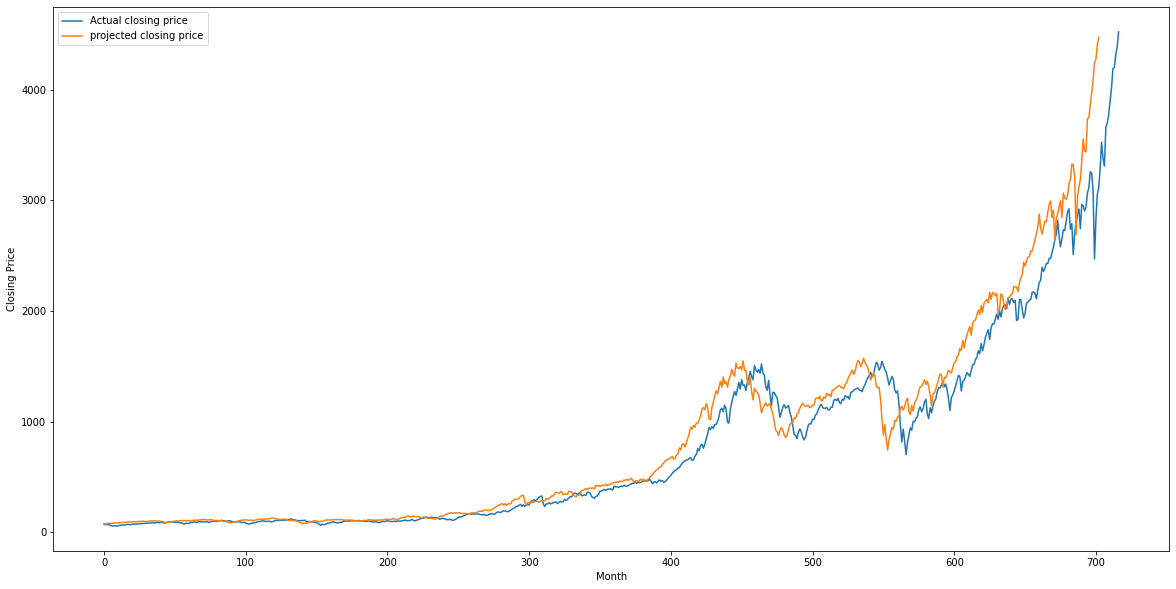

In [74]:
plt.figure(figsize=(20,10))
training = SNP[:]
# valid = SNP[train_size:]
# valid['pred'] = predicted_price_mul
projection = predicted_price_reversed

#plot
plt.xlabel('Month')
# plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.plot(training["Closing Price"], label = 'Actual closing price')
# plt.plot(valid[['Closing Price', 'pred']])
plt.plot(projection, label = 'projected closing price')
plt.legend()
plt.show()


In [75]:
# model performance metric
# MSE
print("MSE: %.10f" % (mean_squared_error(SNP_price[0:len(SNP_price)-time_step], predicted_price)))
print("R2: %.5f" % (r2_score(SNP_price[0:len(SNP_price)-time_step], predicted_price)))

MSE: 0.0024572891
R2: 0.91857
